In [20]:
import numpy as np
import cv2

def mutual_information(image1, image2, bins=256):
    # Calculate the histogram of the images
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

In [21]:
import torch
import random

# Load the images
refered_img = cv2.imread('images/3d-6.tif', cv2.IMREAD_GRAYSCALE)
floated_img = cv2.imread('images/3d-6-2-crop.tif', cv2.IMREAD_GRAYSCALE)

r_img_height, r_img_width = refered_img.shape
f_img_height, f_img_width  = floated_img.shape

print(f"f_width: {f_img_width}, f_height: {f_img_height}")
print(f"r_width: {r_img_width}, r_height: {r_img_height}")

# 生成初始参数规定范围，
minV = [0, 0]
maxV = [r_img_width, r_img_height]

parameters_num = 2
particle_num = 100
iteratons = 10

weight_inertia = 0.5  # Inertia weight
individual_w = 1.6    # Cognitive (particle's best) weight
global_w = 2.6    # Social (swarm's best) weight
speed = 5 # 粒子移动的速度


f_width: 114, f_height: 83
r_width: 288, r_height: 216


In [22]:
# 目前只考虑平移变换
def fintess(x):
    center_x = int(x[0])
    center_y = int(x[1])
    center = (center_x, center_y)

    M = cv2.getRotationMatrix2D(center, 0, 1.0)
    img_transform = cv2.warpAffine(refered_img, M, (r_img_width, r_img_height))
    
    if center_x < 0 or center_y < 0:
        print("x less zero!")

    # 还是以浮动图像的中心作为旋转轴
    # Calculate the coordinates of the top-left corner of the cropped region
    x_tl = int(center_x - f_img_width / 2)
    y_tl = int(center_y - f_img_height / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y_tl, y_tl + f_img_height  # Example row range
    start_col, end_col = x_tl, x_tl + f_img_width  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[img_transform[i][j] if i >= 0 and i < len(img_transform) and j >= 0 and j < len(img_transform[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]

    cropped_image = np.array(cropped)
    mi_value = mutual_information(cropped_image, floated_img)

    return mi_value, cropped_image


# 需要进行调参，惯性权重，个体最优系数，种群最有系数
# 采用环形边界的方式将点限制在一个范围内
def constrain(t):
    item_num = t.numel()
    if t[0] < 0 or t[1] < 0:
        print(f"x less zero! item_num: {item_num}")

    for i in range(item_num):
        if t[i] < minV[i]:
            t[i] = maxV[i] - (minV[i] - t[i])
        elif t[i] > maxV[i]:
            t[i] = minV[i] + (t[i] - maxV[i])
    return t

# Particle class
class Particle:

    def setBest(self):
        self.isBest = True

    def __init__(self, x0):
        self.isBest = False
        self.position = x0
        self.velocity = torch.rand_like(x0)
        self.best_position = x0
        self.best_value,_ = fintess(x0)

    def update_velocity(self, global_best_position):
        r1 = random.random()
        r2 = random.random()

        # if self.isBest :
        #     print("break here.")

        cog_dir = torch.zeros_like(global_best_position)
        cog_delta = (self.best_position - self.position)
        cog_norm = torch.norm(cog_delta)
        if cog_norm > 0:
            cog_dir = cog_delta / cog_norm 
        cognitive_velocity = individual_w * r1 * cog_dir

        soc_dir = torch.zeros_like(global_best_position)
        soc_delta = (global_best_position - self.position)
        soc_norm = torch.norm(soc_delta)
        if soc_norm > 0:
            soc_dir = soc_delta / soc_norm
        social_velocity = global_w * r2 * soc_dir
        self.velocity = weight_inertia * self.velocity + cognitive_velocity + social_velocity

    def move(self):
        self.position += self.velocity * speed
        # constrain the position in a range
        self.position = constrain(self.position)

        value,_ = fintess(self.position)

        if value > self.best_value:
            self.best_position = self.position
            self.best_value = value


# PSO algorithm
def algorithm(particle_vals, num_iterations, record):
    particles = [Particle(particle_vals[i]) for i in range(len(particle_vals))]
    global_best_position = max(particles, key=lambda p: p.best_value).position.clone()

    for _ in range(num_iterations):
        global_best_val, __ = fintess(global_best_position)
        if record != None: record.append(global_best_position.numpy())
        print(f"iterations: {_}, fitness: {global_best_val}, params: {global_best_position}")
        local_best = global_best_val
        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.move()
            if particle.best_value > local_best:
                # particle.setBest()
                local_best = particle.best_value
                global_best_position = particle.best_position.clone()

    return global_best_position

In [23]:
poses = [torch.tensor([random.random() * (maxV[j] - minV[j]) + minV[j] for j in range(parameters_num)]) for i in range(particle_num)]

records = []
# Running PSO
best_position = algorithm(poses, iteratons, records)
print(f"The best position found is: {best_position}")
val,best_regi_img = fintess(best_position)
print(f"The maximum value of the function is: {val}")

iterations: 0, fitness: 0.914550580400005, params: tensor([226.8154, 153.8139])
iterations: 1, fitness: 0.9201187829124174, params: tensor([227.8338, 158.6697])
iterations: 2, fitness: 0.9837044112777231, params: tensor([218.3580, 154.2127])
iterations: 3, fitness: 1.0878061281016376, params: tensor([221.1936, 155.7552])
iterations: 4, fitness: 1.0878061281016376, params: tensor([221.1936, 155.7552])
iterations: 5, fitness: 1.0878061281016376, params: tensor([221.1936, 155.7552])
iterations: 6, fitness: 1.1061514508073, params: tensor([220.2399, 156.4696])
iterations: 7, fitness: 1.1061514508073, params: tensor([220.2399, 156.4696])
iterations: 8, fitness: 1.1061514508073, params: tensor([220.2399, 156.4696])
iterations: 9, fitness: 4.772170662838053, params: tensor([220.0416, 155.2661])
The best position found is: tensor([220.0416, 155.2661])
The maximum value of the function is: 4.772170662838053


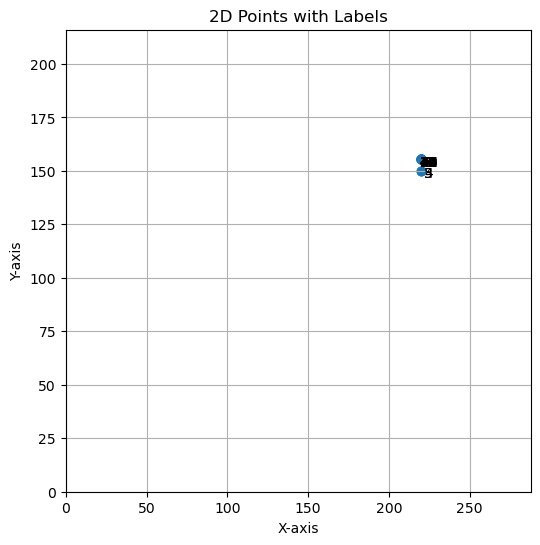

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: an array of points and their corresponding labels
# Replace this with your actual array of 2D points and labels
points = np.array(records)
labels = np.arange(len(points))

# Unpack the points into x and y coordinates
x, y = points[:, 0], points[:, 1]

# Create a figure and axis with a specific size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figure size

# Set the limits of x and y axis based on your points range
ax.set_xlim([0, r_img_width])
ax.set_ylim([0, r_img_height])

# Scatter plot
ax.scatter(x, y)

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5,-5), ha='center')

# Optionally, add grid, labels, title, etc.
ax.grid(True)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Points with Labels')

plt.show()


fitness: 4.772170662838053
mi: 0.8959005594088301
center: (220, 155)


(<AxesSubplot: title={'center': 'best_regi_img'}>,
 Text(0.5, 1.0, 'best_regi_img'))

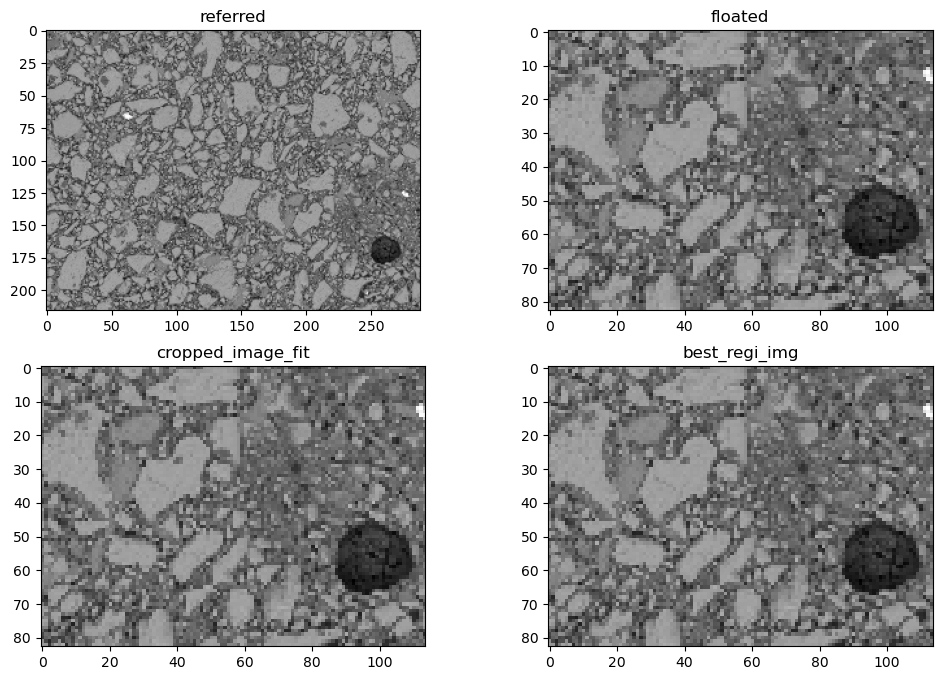

In [24]:
# crop 裁剪图片

import cv2
import matplotlib.pyplot as plt

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[0]  # Example row range
    start_col, end_col = x, x + size[1]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i >= 0 and i < len(rotated) and j >= 0 and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]
    # cropped = rotated[y:y + size[1], x:x + size[0]]

    return cropped

# Specify center, size, and angle
center = (int(best_position[0]), int(best_position[1]))  # Example center position (x, y)
size = (f_img_height, f_img_width)      # Example size (height, width)
angle = 0           # Example rotation angle in degrees

# Crop and rotate
cropped_image = crop_rotate(refered_img, center, size, angle)

# test my fitness ok? okay.
test_p = [220., 155.]
tesnor_p = torch.tensor(test_p)

fitness_val, cropped_image_fit = fintess(test_p)

test_cropped_image = np.array(crop_rotate(refered_img, test_p, size, angle))
print(f"fitness: {fitness_val}")
print(f"mi: {mutual_information(floated_img, test_cropped_image)}")
print(f"center: {center}")

# Display the images
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(refered_img, cmap='gray'), plt.title('referred')
plt.subplot(2, 2, 2), plt.imshow(floated_img, cmap='gray'), plt.title('floated')
plt.subplot(2, 2, 3), plt.imshow(cropped_image_fit, cmap='gray'), plt.title('cropped_image_fit')
plt.subplot(2, 2, 4), plt.imshow(best_regi_img, cmap='gray'), plt.title('best_regi_img')

# Question: 
# 1. 使用的坐标系是哪个？需要确定裁剪区域在图像的哪一位置。图像是先进行了旋转，再进行了移动，先不管旋转后的超出区域直接丢弃的处理。
# 2. 裁剪超过对应区域怎么办？用0填充